<center><h1 class="list-group-item list-group-item-success">Arrhythmia Detection</h1></center>

<center><img src = "https://res.cloudinary.com/qna/image/upload/v1636913992/heart-arrhythmia_f8yxcp.jpg"></center>

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Research Objective</font></h4>
    </strong>
</div><br>
<font size = 4>Comparing accuracy of Convolutional Neural Networks (CNN), Dense Neural Networks(DNN), Long Short Term Memory(LSTM) in arrhythmia detetction on graphical representation of electrocardiographic signals.</font><br><br><br>

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Data Description</font></h4>
    </strong>
</div><br>
<font size = 4>The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.<br>

The recordings were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range. Two or more cardiologists independently annotated each record; disagreements were resolved to obtain the computer-readable reference annotations for each beat (approximately 110,000 annotations in all) included with the database.
Predict if a heart beat from the first ECG signal has an arrhythmia for each 6 second window centered on the peak of the heart beat.<br>

To simplify the problem, we will assume that a QRS detector is capable of automatically identifying the peak of each heart beat. We will ignore any non-beat annotations and any heart beats in the first or last 3 seconds of the recording due to reduced data. We will use a window of 6 seconds so we can compare the current beat to beats just before and after. This decision was based after talking to a physician who said it is easier to identify if you have something to compare it to.</font><br><br><br>

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Contents</font></h4>
    </strong>
</div><br>
<font size = 3.5 color = "blue">
<li>Importing Packages</li><br>
<li>Importing Data</li><br>
<li>Analysing Data</li><br>
<li>Data Transformation</li><br>
<li>Data Visualization</li><br>
<li>Data Preprocessing</li><br>
<li>Training Models</li><br>
<li>Evaluation Metrics</li><br>
</font>

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Importing Packages</font></h4>
    </strong>
</div>

In [1]:
# Importing Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv1D
import wfdb                            # Package for loading the ecg and annotation
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore") 
import random
from keras.layers import Bidirectional, LSTM
# Random Initialization
random.seed(42)

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Importing Data</font></h4>
    </strong>
</div>

In [2]:
# Importing Data
data = '../input/mit-bih-arrhythmia-database/'

In [3]:
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Analysing Data</font></h4>
    </strong>
</div>

In [4]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in patients:
    # Generating filepath for all .atr file names
    file = data + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

In [5]:
# Symbols Dataframe
symbols_df

,symbol,Counts,Patient Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234


In [6]:
# Value Counts of Different symbols in data
symbols_df.groupby('symbol').Counts.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Data Transformation</font></h4>
    </strong>
</div>

In [7]:
# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Normal Beat Symbols
normal = ['N']

In [8]:
# Classifying normal, abnormal or nonbeat
symbols_df['category'] = -1
symbols_df.loc[symbols_df.symbol == 'N','category'] = 0
symbols_df.loc[symbols_df.symbol.isin(abnormal), 'category'] = 1

In [9]:
# Value counts of different categories
symbols_df.groupby('category').Counts.sum()

category
-1     3186
 0    75052
 1    34409
Name: Counts, dtype: int64

In [10]:
def load_ecg(file):    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [11]:
# Accessing the ecg points for 
file = data + patients[8]

In [12]:
# Accessing the load ECG function and getting annotation.symbol, annotation.sample, signals
p_signal, atr_sym, atr_sample = load_ecg(file)

In [13]:
# Analysing annotations value counts for a single record
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Data Visualization</font></h4>
    </strong>
</div>

In [14]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[4105, 10876, 83824, 107330, 180041, 180621, 193553, 205731, 221206, 263192]

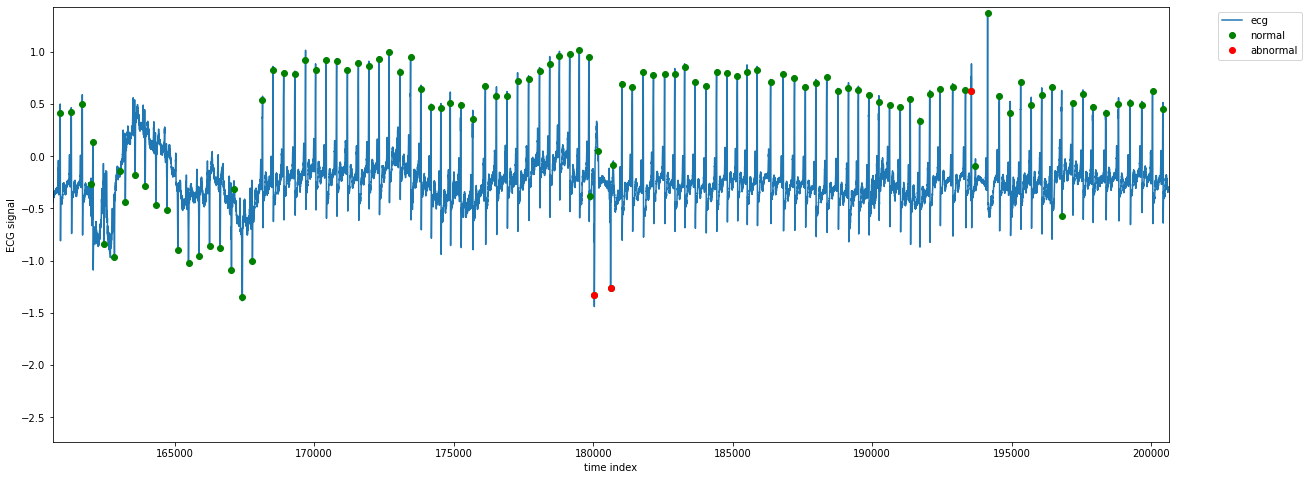

In [15]:
# Generating evenly spaced values
x = np.arange(len(p_signal))

left = ab_index[5]-20000
right = ab_index[5]+20000

plt.figure(figsize=(20,8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Data Preprocessing</font></h4>
    </strong>
</div>

In [16]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    #   pts - list of patients
    #   num_sec = number of seconds to include before and after the beat
    #   fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
        
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all


In [17]:
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [18]:
# Parameter Values
num_sec = 3
fs = 360

In [19]:
# Accessing the fuction and creating a dataset with ECG digital Points
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, abnormal)

In [20]:
# Train Test Split
X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Training Models</font></h4>
    </strong>
</div>

<div style="background:#5990f7;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Dense Neural Networks(DNN)</font></h4>
    </strong>
</div>

In [21]:
# Relu for activation function and drop out for regularization
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [22]:
# Compiling model with  binary crossentropy and the adam optimizer
model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [23]:
# Fitting the model
model.fit(X_train, y_train, batch_size = 32, epochs= 10, verbose = 1)

2022-02-19 20:45:13.707102: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2285/2285 [==============================] - 7s 3ms/step - loss: 0.2437 - accuracy: 0.9077
Epoch 2/10
2285/2285 [==============================] - 7s 3ms/step - loss: 0.1619 - accuracy: 0.9470
Epoch 3/10
2285/2285 [==============================] - 6s 3ms/step - loss: 0.1462 - accuracy: 0.9540
Epoch 4/10
2285/2285 [==============================] - 7s 3ms/step - loss: 0.1344 - accuracy: 0.9575
Epoch 5/10
2285/2285 [==============================] - 6s 3ms/step - loss: 0.1265 - accuracy: 0.9612
Epoch 6/10
2285/2285 [==============================] - 6s 3ms/step - loss: 0.1213 - accuracy: 0.9627
Epoch 7/10
2285/2285 [==============================] - 7s 3ms/step - loss: 0.1125 - accuracy: 0.9654
Epoch 8/10
2285/2285 [==============================] - 6s 3ms/step - loss: 0.1132 - accuracy: 0.9649
Epoch 9/10
2285/2285 [==============================] - 6s 3ms/step - loss: 0.1092 - accuracy: 0.9660
Epoch 10/10
2285/2285 [==============================] - 6s 3ms/step - loss: 0.106

In [24]:
# Evaluation Metrics
def print_report(y_actual, y_pred, thresh):
    # Function to print evaluation metrics
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
    prevalence = (sum(y_actual)/len(y_actual))
    print('AUC:%.3f'%auc)
    print('Accuracy:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precision:%.3f'%precision)
    print('Specificity:%.3f'%specificity)
    print('Prevalence:%.3f'%prevalence)
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [25]:
# Predictions
y_train_preds_dense = model.predict(X_train,verbose = 1)
y_valid_preds_dense = model.predict(X_valid,verbose = 1)

1126/1126 [==============================] - 2s 2ms/step


In [26]:
# Threshold Value
thresh = (sum(y_train)/len(y_train))[0]

In [27]:
# Accessing Evaluation Metrics Function
print('On Train Data')
print_report(y_train, y_train_preds_dense, thresh)
print('On Valid Data')
print_report(y_valid, y_valid_preds_dense, thresh)

On Train Data
AUC:0.995
Accuracy:0.979
Recall:0.961
Precision:0.971
Specificity:0.987
Prevalence:0.315
 
On Valid Data
AUC:0.990
Accuracy:0.970
Recall:0.949
Precision:0.957
Specificity:0.980
Prevalence:0.314
 


(0.9900715726128928,
 0.9704746826653334,
 0.9487429178470255,
 0.9567895723596107,
 array([0.98041041]))

<div style="background:#5990f7;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Convolutional Neural Networks(CNN)</font></h4>
    </strong>
</div>

In [28]:
# reshape input to [samples, time steps, features = 1] for CNN
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(73096, 2160, 1)
(36003, 2160, 1)


In [29]:
# Relu for activation function & Dropout for reducing overfitting by randomly removing some nodes.
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model with binary crossentropy, and the adam optimizer
model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])


In [30]:
# Fitting data in model
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 2, verbose = 1)

Epoch 1/2
2285/2285 [==============================] - 183s 80ms/step - loss: 0.2110 - accuracy: 0.9268
Epoch 2/2
2285/2285 [==============================] - 184s 80ms/step - loss: 0.1242 - accuracy: 0.9619


In [31]:
# Predictions
y_train_preds_cnn = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict(X_valid_cnn,verbose = 1)

1126/1126 [==============================] - 11s 9ms/step


In [32]:
# Metrics
print('Train');
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh);

Train
AUC:0.989
Accuracy:0.968
Recall:0.928
Precision:0.967
Specificity:0.986
Prevalence:0.315
 
Valid
AUC:0.985
Accuracy:0.962
Recall:0.917
Precision:0.962
Specificity:0.983
Prevalence:0.314
 


<div style="background:#5990f7;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Long Short Term Memory (LSTM)</font></h4>
    </strong>
</div>

In [33]:
# Bidirectional LSTM with Dropout for reducing overfitting by randomly removing some nodes.
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [34]:
# Fitting Data
model.fit(X_train_cnn[:10000], y_train[:10000], batch_size = 32, epochs= 1, verbose = 1)

313/313 [==============================] - 854s 3s/step - loss: 0.6147 - accuracy: 0.6934


In [35]:
# Prediction
y_train_preds_lstm = model.predict(X_train_cnn[:10000],verbose = 1)
y_valid_preds_lstm = model.predict(X_valid_cnn,verbose = 1)

1126/1126 [==============================] - 785s 698ms/step


In [36]:
# Metrics
print('Train');
print_report(y_train[:10000], y_train_preds_lstm, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_lstm, thresh);

Train
AUC:0.589
Accuracy:0.490
Recall:0.751
Precision:0.350
Specificity:0.372
Prevalence:0.311
 
Valid
AUC:0.583
Accuracy:0.483
Recall:0.734
Precision:0.347
Specificity:0.368
Prevalence:0.314
 


#### LSTM is not working good on data because we are using a subset of data

<div style="background:#c72e57;color:#fff;padding:1em 2em 1.5em 2em;border-radius: 3px;font-weight:bold">
    <strong>
        <h4 style = "color:#fff"><font size = 4>Evaluation Metrics</font></h4>
    </strong>
</div>

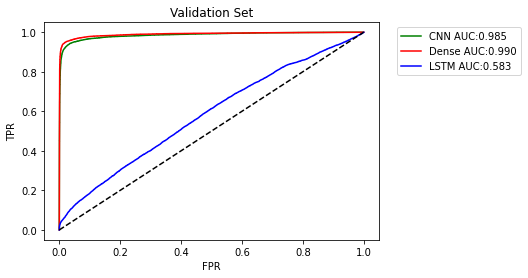

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

fpr_valid_dense, tpr_valid_dense, t_valid_dense = roc_curve(y_valid, y_valid_preds_dense)
auc_valid_dense = roc_auc_score(y_valid, y_valid_preds_dense)

fpr_valid_lstm, tpr_valid_lstm, t_valid_lstm = roc_curve(y_valid, y_valid_preds_lstm)
auc_valid_lstm = roc_auc_score(y_valid, y_valid_preds_lstm)

plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)
plt.plot(fpr_valid_dense, tpr_valid_dense, 'r-', label = 'Dense AUC:%.3f'%auc_valid_dense)
plt.plot(fpr_valid_lstm, tpr_valid_lstm, 'b-', label = 'LSTM AUC:%.3f'%auc_valid_lstm)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()


### Here we can conclude that Dense Layer Network work good on predicting Arrhythmia 😊

<center><h1 class="list-group-item list-group-item-success">Thank You</h1></center>